In [27]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
from cProfile import label
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import random
import powerlaw as pl 

%matplotlib inline

In [28]:
def plot_degree_dist(G):
    
    degrees = [G.degree(n, weight = 'weight') for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=15)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=15)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    print(bin_edges)
    print(density)
    
    fig = plt.figure(figsize=(16,16))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    
    fit = pl.Fit(degrees, xmin=min(degrees), xmax=max(degrees))
    print('gamma= ',fit.truncated_power_law.parameter2)
    fit.power_law.plot_pdf(color='black')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [29]:
df = pd.read_csv('../data/fulldata-name.csv', header=0)
df = df[df['Exporter reported quantity'].notnull()]
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc

taxons = {}
purpose = {}
        
for index, row in df.iterrows():

    details = {"Appendix": row['Appendix'], "Class": row['Class'], "Order": row['Order'], "Family": row['Family'], "Genus": row['Genus']}
    
    if(row['Purpose'] == "B"):
        purposeCode = "Breeding"
    if(row['Purpose'] == "E"):
        purposeCode = "Educational"
    if(row['Purpose'] == "G"):
        purposeCode = "Garden"
    if(row['Purpose'] == "H"):
        purposeCode = "Hunting"
    if(row['Purpose'] == "L"):
        purposeCode = "Law"
    if(row['Purpose'] == "M"):
        purposeCode = "Medical"
    if(row['Purpose'] == "R"):
        purposeCode = "Reintroduction to wild"
    if(row['Purpose'] == "P"):
        purposeCode = "Personal"
    if(row['Purpose'] == "Q"):
        purposeCode = "Circus"
    if(row['Purpose'] == "S"):
        purposeCode = "Scientific"
    if(row['Purpose'] == "T"):
        purposeCode = "Commercial"
    if(row['Purpose'] == "Z"):
        purposeCode = "Zoo"
    if(row['Purpose'] == "Unspecified"):
        purposeCode = "Unspecified"
        
    attributes = {"Details": details}

    taxons.update({row['Taxon']: row['Taxon']})
    if G.has_node(row['Taxon']):
        if purposeCode not in G.nodes[row['Taxon']]['purpose']:  
            G.nodes[row['Taxon']]['purpose'].append(purposeCode)
    else:
        purpose = [purposeCode]
        G.add_node(row['Taxon'], **details, purpose = [purposeCode])

df2 = df.drop_duplicates(['Taxon', 'Exporter'])
for i, group in df2.groupby(['Exporter'])['Taxon']:
    # generate all combinations without replacement 
    # from the group of similar column pairs       
    for u, v in itertools.combinations(group, 2):
        if(G.has_edge(u,v)):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight = 1, countries = [i])

nx.write_gml(G, "taxon-taxon-exporter.gml")



Number of nodes:  1487
Number of edges:  272116

Weighted average degree: 510.9778076664425
Minimum degree:  0
Maximum degree:  3964

[1.00000000e+00 2.13028700e+00 4.53812271e+00 9.66750383e+00
 2.05945577e+01 4.38723187e+01 9.34606302e+01 1.99097966e+02
 4.24135809e+02 9.03531001e+02 1.92478035e+03 4.10033455e+03
 8.73488941e+03 1.86078214e+04 3.96400000e+04]
[1.19155696e-03 1.95769366e-03 1.05026421e-03 2.95809214e-03
 3.15325317e-03 1.41230197e-03 1.12193779e-03 1.04434362e-03
 6.26490848e-04 1.23965148e-04 1.48574704e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
c:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /
c:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


gamma=  0.0009337573919433707


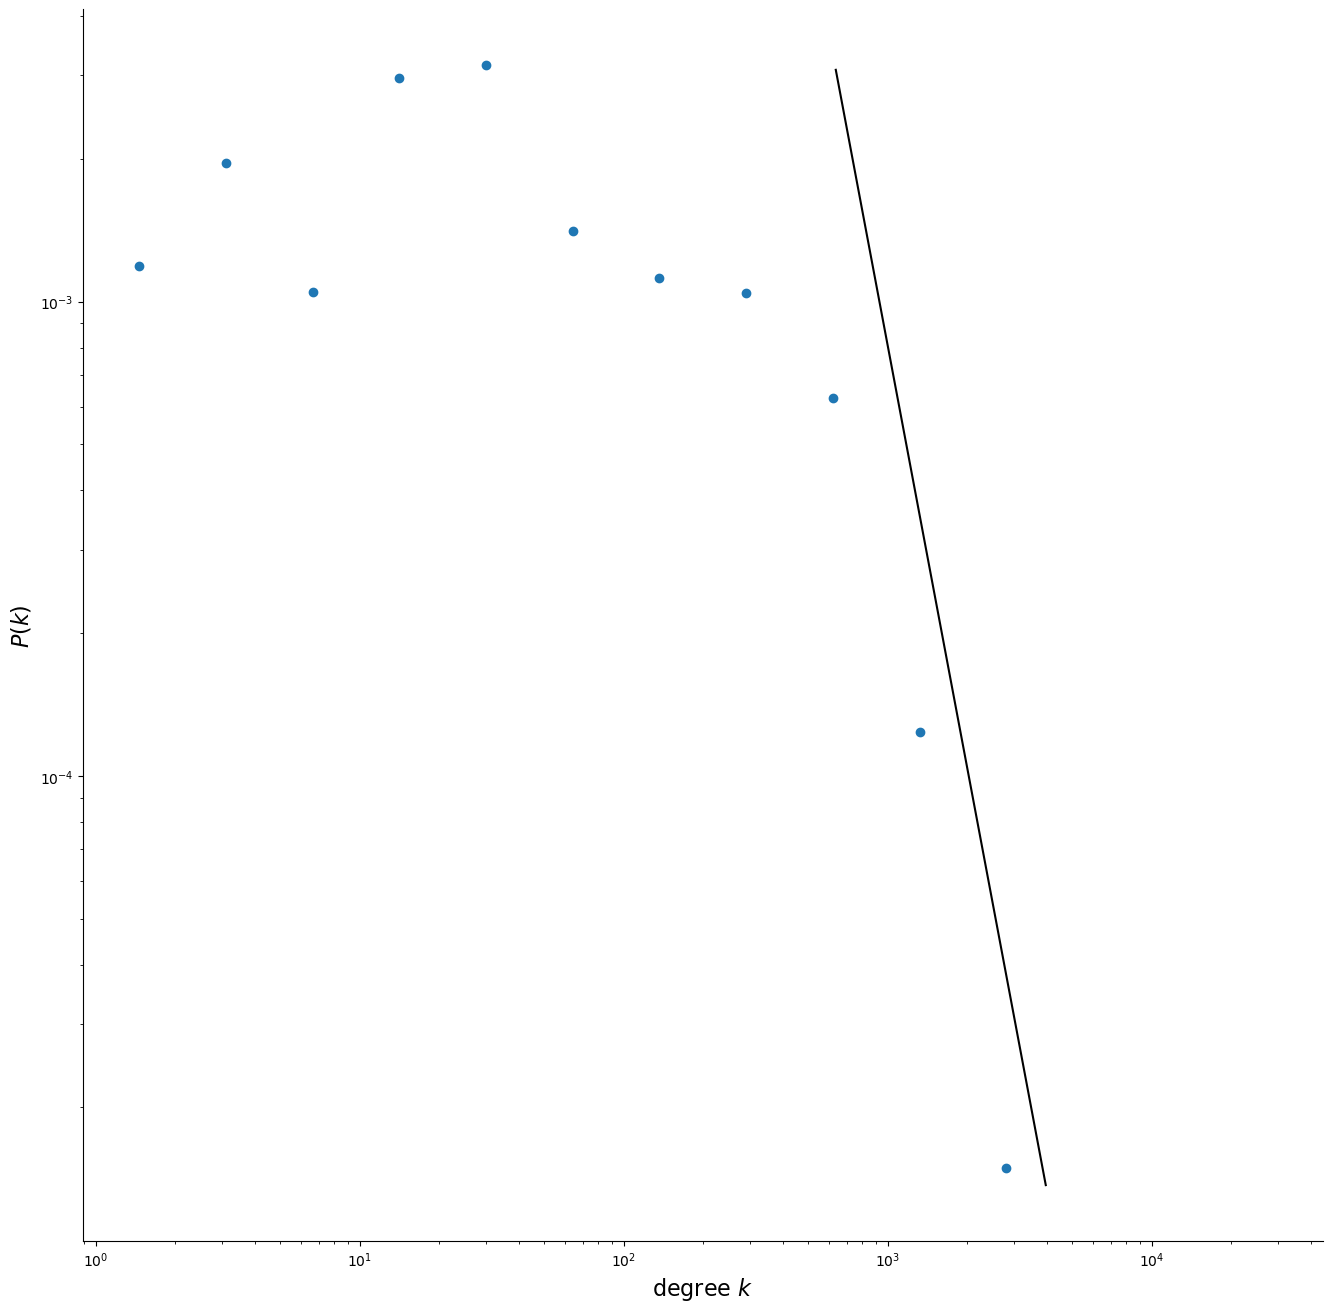

In [30]:
degrees = [G.degree(n, weight = 'weight') for n in G.nodes()]
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())
print()
print("Weighted average degree:", np.mean(degrees))
print("Minimum degree: ", min(degrees))
print("Maximum degree: ", max(degrees))
print()
plot_degree_dist(G)

In [31]:
print("Unweighted average Clustering Coefficient: ", np.mean(list(nx.clustering(G).values())))

print("Weighted average clustering coefficient: ", nx.average_clustering(G, weight='weight'))

print("Number of connected components: ", nx.number_connected_components(G))

for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
    print("Average shortest path length: ", nx.average_shortest_path_length(C))

Unweighted average Clustering Coefficient:  0.8397814983118916
Weighted average clustering coefficient:  0.032388777024829445
Number of connected components:  3
Average shortest path length:  1.7756486699882927
Average shortest path length:  0
Average shortest path length:  0


[1.00000000e+00 2.12683448e+00 4.52342492e+00 9.62057612e+00
 2.04613730e+01 4.35179538e+01 9.25554848e+01 1.96850197e+02
 4.18667787e+02 8.90437087e+02 1.89381230e+03 4.02782531e+03
 8.56651777e+03 1.82195654e+04 3.87500000e+04]
[1.19520778e-03 1.96687954e-03 1.05690516e-03 2.98162880e-03
 3.21270855e-03 1.45562939e-03 1.15575103e-03 1.15361571e-03
 6.73729973e-04 9.66435043e-05 9.15112487e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


gamma=  0.0006212076612932722
[1.00000000e+00 2.13028700e+00 4.53812271e+00 9.66750383e+00
 2.05945577e+01 4.38723187e+01 9.34606302e+01 1.99097966e+02
 4.24135809e+02 9.03531001e+02 1.92478035e+03 4.10033455e+03
 8.73488941e+03 1.86078214e+04 3.96400000e+04]
[1.19155696e-03 1.95769366e-03 1.05026421e-03 2.95809214e-03
 3.15325317e-03 1.41230197e-03 1.12193779e-03 1.04434362e-03
 6.26490848e-04 1.23965148e-04 1.48574704e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


gamma=  0.0009337573919433707


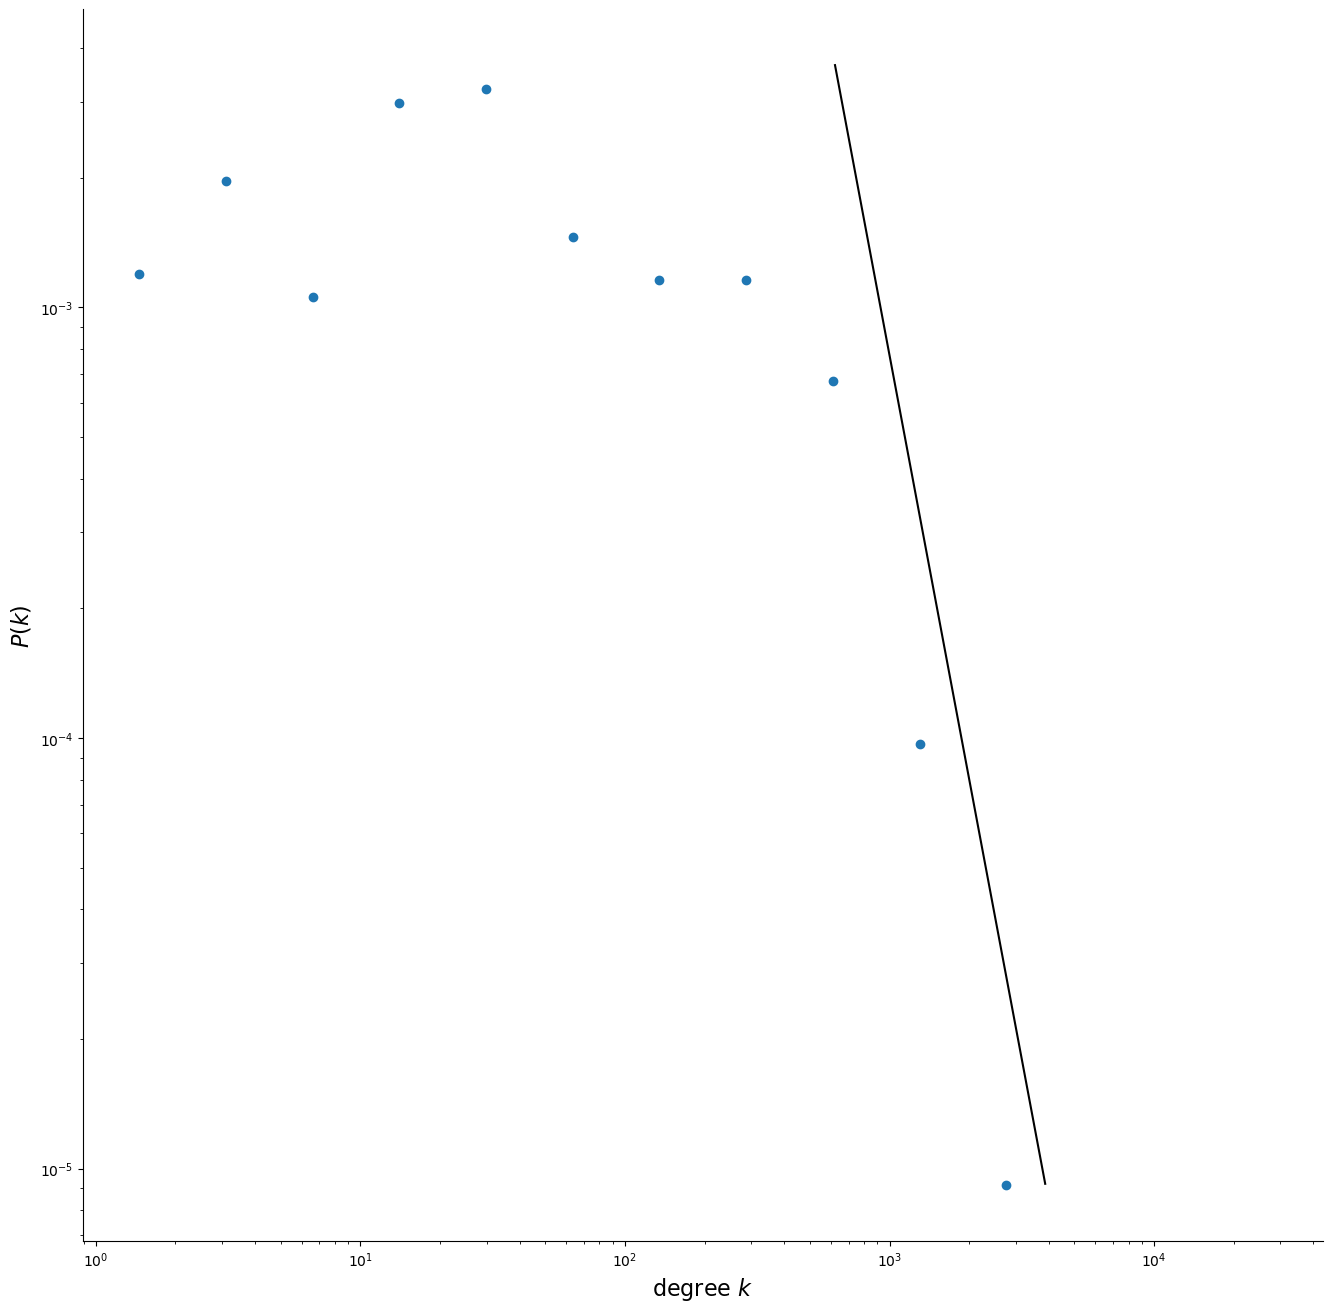

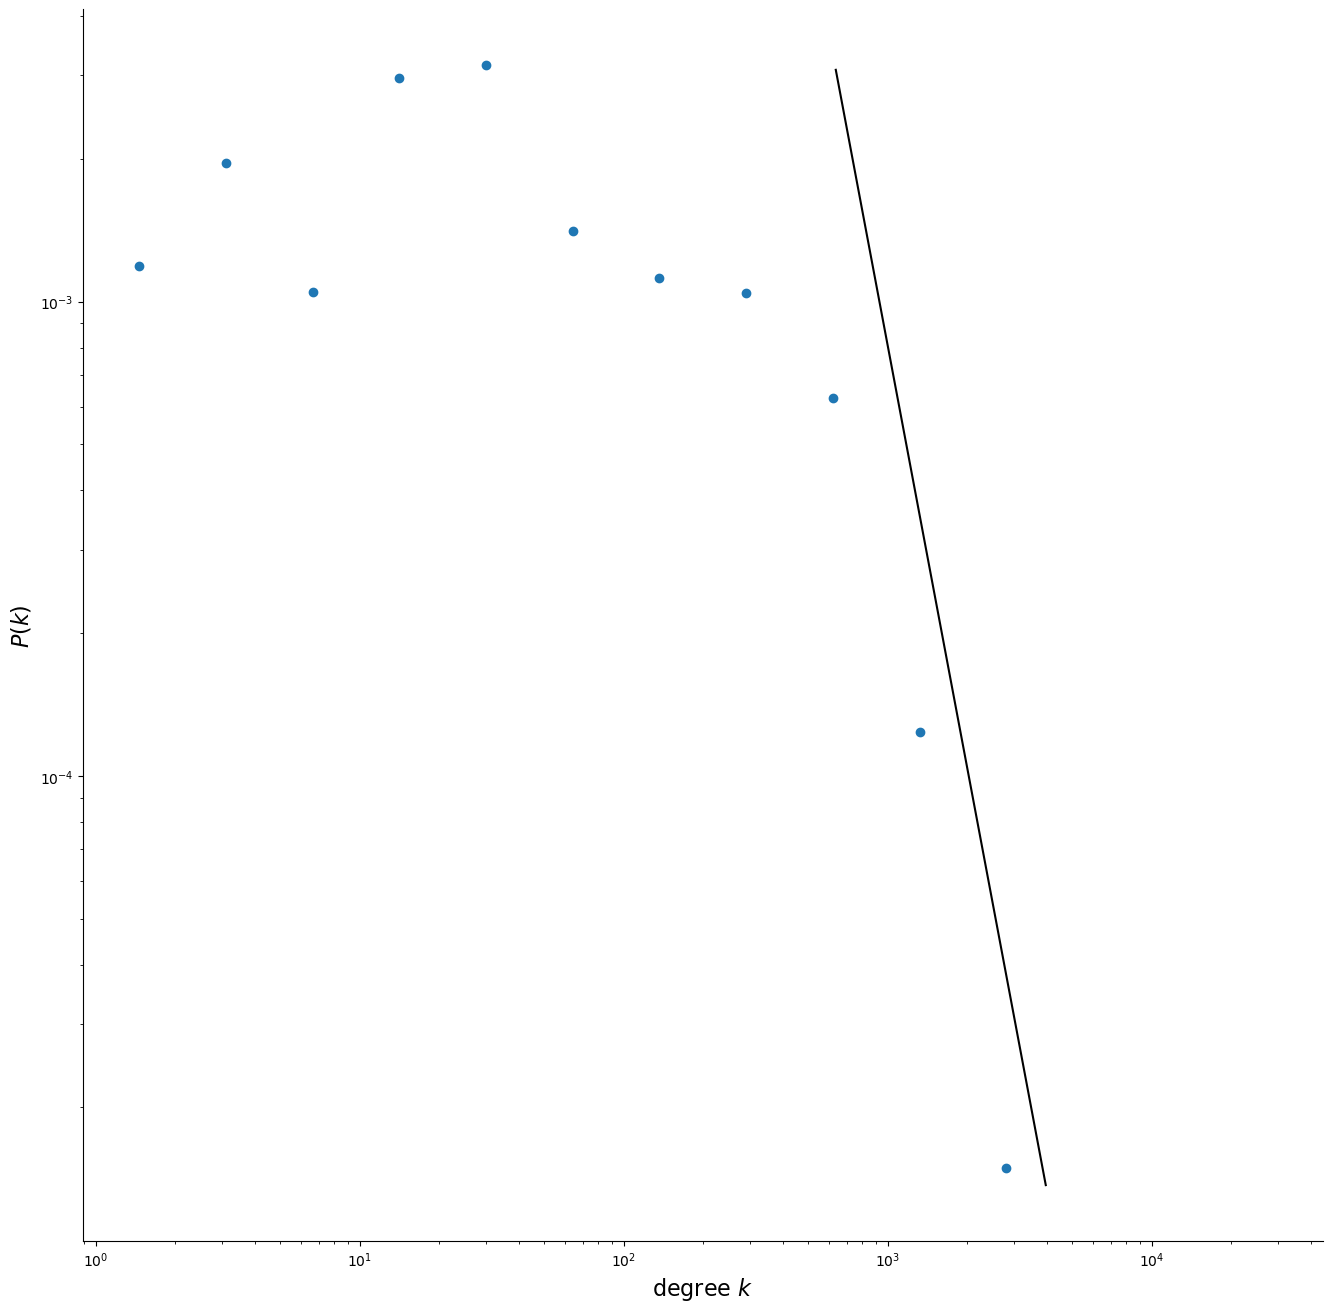

In [32]:
DP = G.copy() # the function edits the graph in place

nx.double_edge_swap(DP,nswap=G.number_of_edges(),max_tries=10000000)
plot_degree_dist(DP)
plot_degree_dist(G)

In [33]:
clustering_DP = []
short_path_DP = []

for i in range(100): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=G.number_of_edges(),max_tries=10000000)
    C_DP = np.mean(list(nx.clustering(DP).values()))
    if nx.is_connected(DP)==True:
        d_DP = nx.average_shortest_path_length(DP,weight=None)
    else:
        for C in (G.subgraph(c).copy() for c in nx.connected_components(DP)):
            if(nx.average_shortest_path_length(C) > 0):
                d_DP = nx.average_shortest_path_length(C)
    clustering_DP.append(C_DP)
    short_path_DP.append(d_DP)
    
print(np.mean(clustering_DP))
print(np.std(clustering_DP))

print(np.mean(short_path_DP))
print(np.std(short_path_DP))